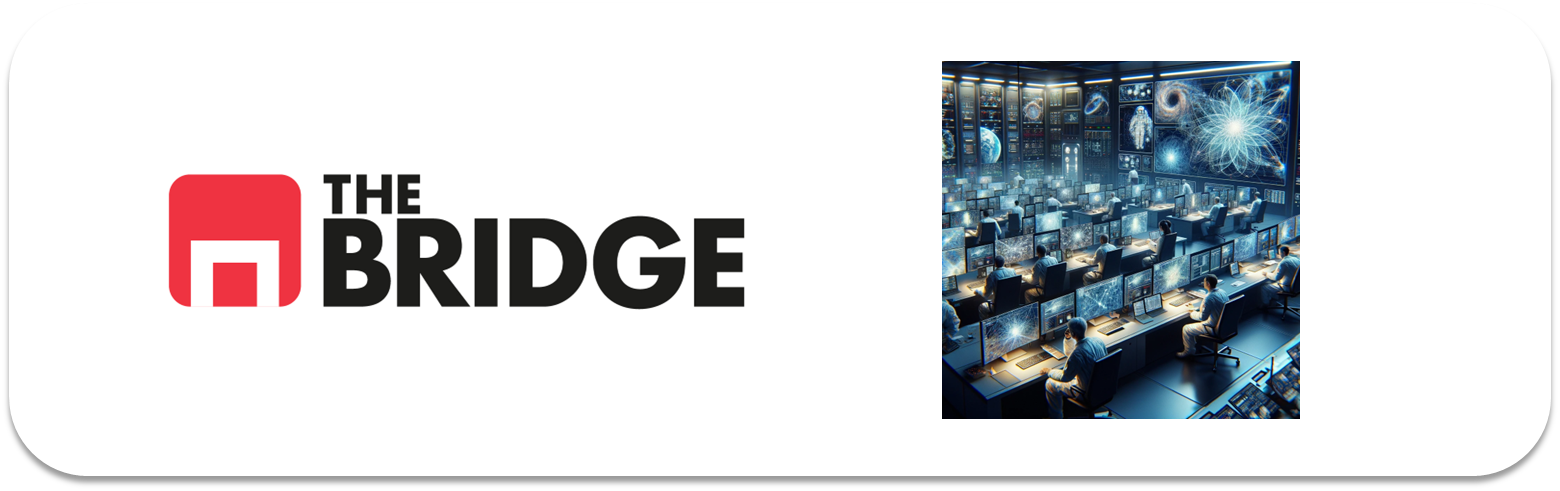

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [46]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import tensorflow as tf
import pandas as pd


# Preprocesado y modelado
# ==============================================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



**1. DESCARGA Y EXTRACCIÓN DE DATOS**

In [47]:
train_dir = 'data/seg_train'
pred_dir = 'data/seg_pred' 
test_dir = 'data/seg_test'

Voy a configurar los generadores de datos con ImageDataGenerator.

In [48]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [49]:
train_generator = train_data_gen.flow_from_directory(directory=train_dir,
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     subset='training')

validation_generator = train_data_gen.flow_from_directory(directory=train_dir,
                                                          target_size=(224, 224),
                                                          batch_size=32,
                                                          class_mode='categorical',
                                                          subset='validation')

test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(directory=test_dir,
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='categorical',
                                                   subset= 'training')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [50]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size
print(f'{steps_per_epoch} y {validation_steps}')

350 y 87


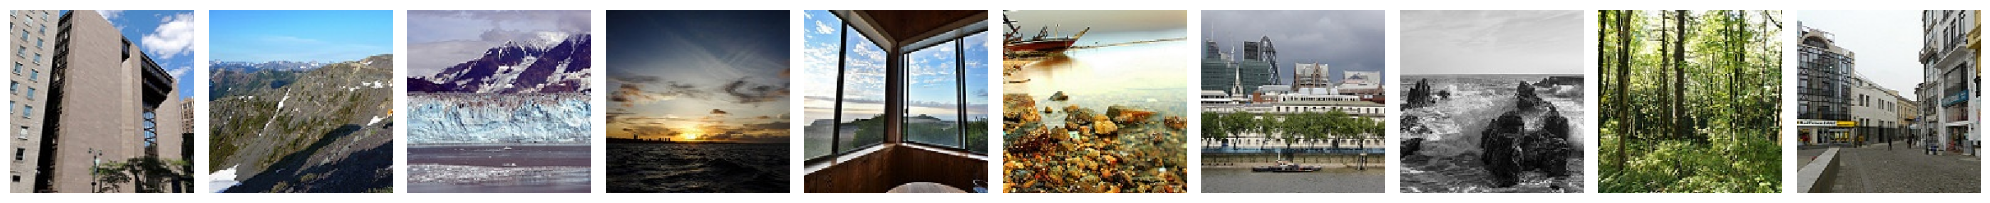

In [51]:
sample_training_images, _ = next(train_generator)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:10])

**2. Entrenamiento y Evaluación de los Modelos**

2.1. Ad-Hoc

Lo primero es definir y entrenar una red convolucional Ad-hoc desde cero.
Pasos:

- Definir la arquitectura de la red convolucional.
- Compilar el modelo.
- Entrenar el modelo utilizando el conjunto de entrenamiento.
- Evaluar el modelo con el conjunto de prueba.

In [52]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [53]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
model.summary

<bound method Model.summary of <Sequential name=sequential_5, built=True>>

In [55]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.4582 - loss: 1.9273 - val_accuracy: 0.7026 - val_loss: 0.8541
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step - accuracy: 0.7500 - loss: 0.7064 - val_accuracy: 0.7500 - val_loss: 0.7610
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 435s 1s/step - accuracy: 0.6931 - loss: 0.8452 - val_accuracy: 0.7367 - val_loss: 0.7558
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - accuracy: 0.6875 - loss: 0.8879 - val_accuracy: 0.7500 - val_loss: 0.6532
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.7679 - loss: 0.6535 - val_accuracy: 0.7597 - val_loss: 0.6964
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 930us/step - accuracy: 0.7500 - loss: 0.8512 - val_accuracy: 0.8000 - val_loss: 0.5901
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.8111 - loss: 0.5213 - val_accuracy: 0.7741 - val_loss: 0.6870
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 524us/step - accuracy: 0.9375 - loss: 0.2049 - val_

In [56]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'\nTest accuracy: {test_acc}')

94/94 - 42s - 448ms/step - accuracy: 0.7653 - loss: 0.7589

Test accuracy: 0.765333354473114


2.2. Transfer Learning con MobileNetV2

Voy a utilizar un modelo preentrenado (MobileNetV2) y añadir una nueva cabeza para nuestro problema.
Pasos:
- Cargar el modelo base MobileNetV2 sin la capa superior.
- Congelar el modelo base.
- Añadir una cabeza personalizada.
- Compilar y entrenar el modelo.
- Evaluar el modelo con el conjunto de prueba.

In [57]:
# Transfer Learning con MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [58]:
# Congelar el modelo base
base_model.trainable = False

In [59]:
# Añadir la cabeza personalizada
model_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [60]:
model_tl.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [61]:
model_tl.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [62]:
# Entrenar el modelo
history_tl = model_tl.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - accuracy: 0.7950 - loss: 0.5651 - val_accuracy: 0.9023 - val_loss: 0.2584
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9688 - loss: 0.2571 - val_accuracy: 1.0000 - val_loss: 0.0337
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.8964 - loss: 0.2860 - val_accuracy: 0.9120 - val_loss: 0.2522
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.6155 - val_accuracy: 0.9500 - val_loss: 0.0984
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.9045 - loss: 0.2509 - val_accuracy: 0.9077 - val_loss: 0.2475
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 0.0654 - val_accuracy: 0.9500 - val_loss: 0.1142
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9137 - loss: 0.2321 - val_accuracy: 0.9177 - val_loss: 0.2426
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9688 - loss: 0.1638 - val_accuracy

In [63]:
# Evaluar el modelo
test_loss_tl, test_acc_tl = model_tl.evaluate(test_generator, verbose=2)
print(f'\nTest accuracy: {test_acc_tl}')

94/94 - 101s - 1s/step - accuracy: 0.9103 - loss: 0.2451

Test accuracy: 0.9103333353996277


2.3. Fine-Tuning del Modelo Preentrenado

El objetivo es ajustar los pesos de las capas superiores del modelo preentrenado junto con la nueva cabeza.
Pasos:
- Descongelar algunas capas del modelo base.
- Compilar el modelo con una tasa de aprendizaje más baja.
- Entrenar el modelo nuevamente.
- Evaluar el modelo con el conjunto de prueba.


In [64]:
# Fine-Tuning del Modelo Preentrenado
base_model.trainable = True

In [65]:
# Congelar todas las capas hasta la capa que deseamos ajustar
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [66]:
# Compilar el modelo con una tasa de aprendizaje más baja
model_ft = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [67]:
model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [68]:
model_ft.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [69]:
# Entrenar el modelo
history_ft = model_ft.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.3652 - loss: 1.6272 - val_accuracy: 0.7446 - val_loss: 0.7280
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7812 - loss: 0.8044 - val_accuracy: 0.5500 - val_loss: 1.0237
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.7634 - loss: 0.6766 - val_accuracy: 0.8319 - val_loss: 0.4413
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6875 - loss: 0.6448 - val_accuracy: 0.8000 - val_loss: 0.5084
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.8416 - loss: 0.4602 - val_accuracy: 0.8721 - val_loss: 0.3508
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - loss: 0.6676 - val_accuracy: 0.8500 - val_loss: 0.3538
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 668s 2s/step - accuracy: 0.8757 - loss: 0.3764 - val_accuracy: 0.8908 - val_loss: 0.3050
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9375 - loss: 0.1897 - val_accuracy

In [70]:
# Evaluar el modelo
test_loss_ft, test_acc_ft = model_ft.evaluate(test_generator, verbose=2)
print(f'\nTest accuracy: {test_acc_ft}')

94/94 - 88s - 935ms/step - accuracy: 0.9027 - loss: 0.2779

Test accuracy: 0.9026666879653931


**3. Evaluación y Comparación de Resultados**

Es la hora de generar informes de clasificación y matrices de confusión para comparar los resultados de los diferentes modelos.

In [71]:
# Generar predicciones para el conjunto de prueba
predictions = model.predict(test_generator)
predictions_tl = model_tl.predict(test_generator)
predictions_ft = model_ft.predict(test_generator)

94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 96s 999ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 91s 943ms/step


In [72]:
# Convertir las predicciones y las etiquetas reales a etiquetas categóricas
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

y_pred_tl = np.argmax(predictions_tl, axis=1)
y_pred_ft = np.argmax(predictions_ft, axis=1)

In [73]:
# Generar los informes de clasificación
print("Red Convolucional Ad-hoc")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

print("Transfer Learning")
print(classification_report(y_true, y_pred_tl, target_names=test_generator.class_indices.keys()))

print("Fine-Tuning")
print(classification_report(y_true, y_pred_ft, target_names=test_generator.class_indices.keys()))

Red Convolucional Ad-hoc
              precision    recall  f1-score   support

   buildings       0.18      0.17      0.17       437
      forest       0.15      0.16      0.16       474
     glacier       0.18      0.23      0.20       553
    mountain       0.18      0.21      0.19       525
         sea       0.19      0.12      0.14       510
      street       0.16      0.16      0.16       501

    accuracy                           0.18      3000
   macro avg       0.18      0.17      0.17      3000
weighted avg       0.18      0.18      0.17      3000

Transfer Learning
              precision    recall  f1-score   support

   buildings       0.15      0.15      0.15       437
      forest       0.13      0.14      0.13       474
     glacier       0.18      0.14      0.16       553
    mountain       0.19      0.13      0.16       525
         sea       0.18      0.27      0.21       510
      street       0.15      0.15      0.15       501

    accuracy                      

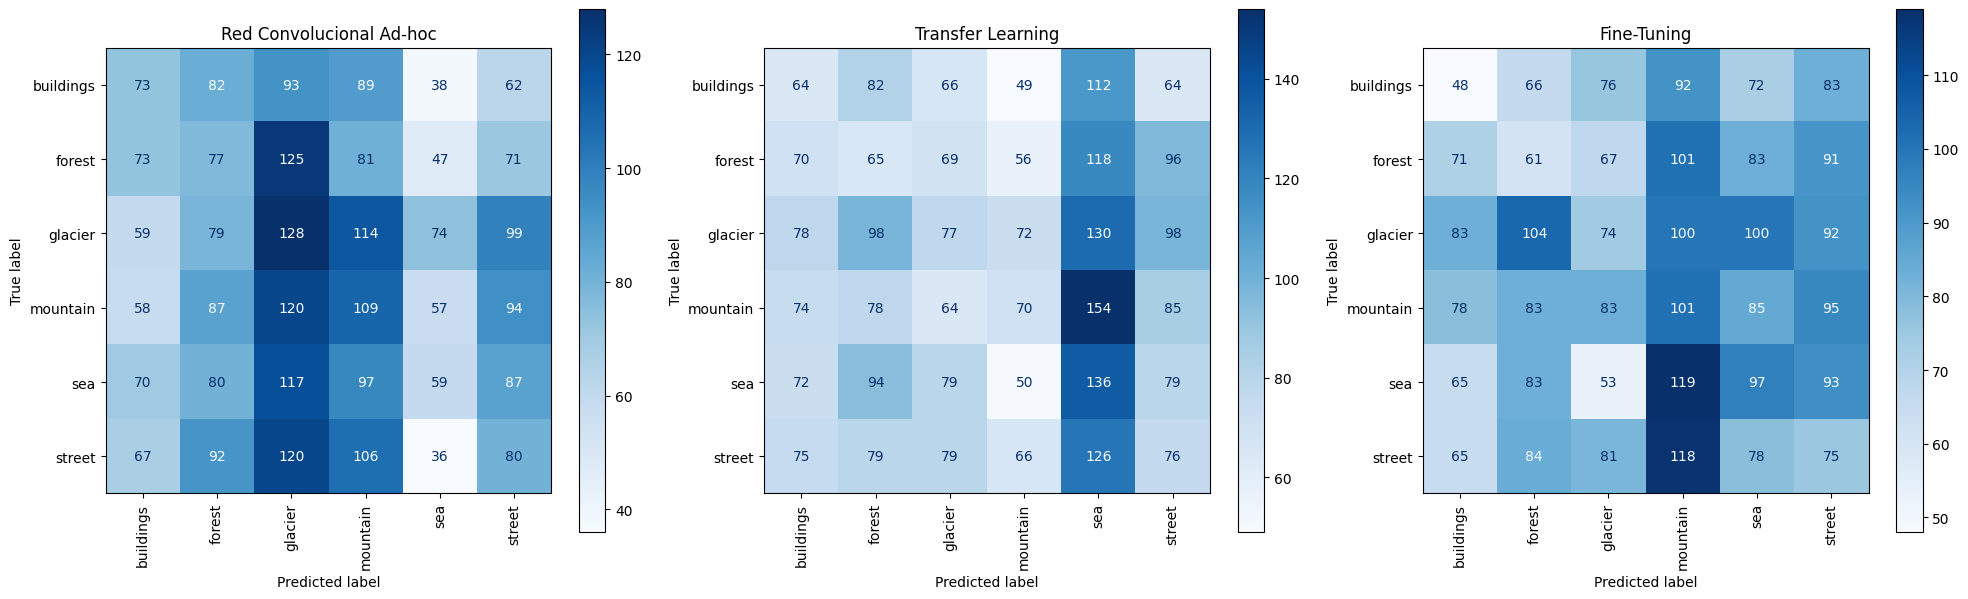

In [74]:
# Generar las matrices de confusión y visualizarlas
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

cm = confusion_matrix(y_true, y_pred)
cm_tl = confusion_matrix(y_true, y_pred_tl)
cm_ft = confusion_matrix(y_true, y_pred_ft)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(ax=axes[0], cmap='Blues', xticks_rotation='vertical')
axes[0].set_title('Red Convolucional Ad-hoc')

disp_tl = ConfusionMatrixDisplay(confusion_matrix=cm_tl, display_labels=test_generator.class_indices.keys())
disp_tl.plot(ax=axes[1], cmap='Blues', xticks_rotation='vertical')
axes[1].set_title('Transfer Learning')

disp_ft = ConfusionMatrixDisplay(confusion_matrix=cm_ft, display_labels=test_generator.class_indices.keys())
disp_ft.plot(ax=axes[2], cmap='Blues', xticks_rotation='vertical')
axes[2].set_title('Fine-Tuning')

plt.tight_layout()
plt.show()

In [75]:
# (Opcional) Transfer Learning con Aumento de Imágenes
train_image_generator_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [76]:
train_data_gen_aug = train_image_generator_aug.flow_from_directory(directory=train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='categorical',
                                                                   subset='training')

Found 11230 images belonging to 6 classes.


In [77]:
validation_data_gen_aug = train_image_generator_aug.flow_from_directory(directory=train_dir,
                                                                        target_size=(224, 224),
                                                                        batch_size=32,
                                                                        class_mode='categorical',
                                                                        subset='validation')

Found 2804 images belonging to 6 classes.


In [78]:
validation_data_gen_aug = train_image_generator_aug.flow_from_directory(directory=train_dir,
                                                                        target_size=(224, 224),
                                                                        batch_size=32,
                                                                        class_mode='categorical',
                                                                        subset='validation')

Found 2804 images belonging to 6 classes.


In [79]:
test_loss_tl_aug, test_acc_tl_aug = model_tl.evaluate(test_generator, verbose=2)
print(f'\nTest accuracy with augmentation: {test_acc_tl_aug}')

94/94 - 94s - 997ms/step - accuracy: 0.8387 - loss: 0.5141

Test accuracy with augmentation: 0.8386666774749756
